<a href="https://colab.research.google.com/github/RotemBorenstein/Pyspark-Databricks-Project/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col, udf, row_number, when, lit
import os,time
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, MinMaxScaler, PCA
from pyspark.ml import Pipeline
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.ml.linalg import VectorUDT, Vectors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import Window

spark = SparkSession.builder.appName("my_project_2").getOrCreate()
sc = spark.sparkContext

# read data

In [ ]:
demographic_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_demographic.parquet")

demographic_df = demographic_df.withColumn("household_id", col("household_id").cast(LongType()))

demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: integer (nullable = true)
 |-- net_worth: integer (nullable = true)
 |-- education_highest: integer (nullable = true)
 |-- gender_individual: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,education_highest,gender_individual
15,2,2,1,S,B,S,O,5,5,6,4,M
28,3,2,2,S,W,S,O,3,8,5,2,M
56,2,2,1,S,W,S,O,4,10,5,1,M
61,2,2,2,M,W,S,O,15,8,8,1,M
98,3,2,2,M,W,S,O,4,13,7,1,F
111,2,2,1,S,W,S,O,15,4,8,2,M
122,3,2,2,M,W,S,O,8,7,7,2,F
130,2,2,2,S,W,S,O,8,8,6,2,M
145,1,1,1,B,W,S,O,3,6,5,1,M
160,2,2,1,A,W,S,O,15,6,6,1,M


In [ ]:
static_viewing_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_static_viewing_data.parquet")

static_viewing_df = static_viewing_df.withColumn("household_id", col("household_id").cast(LongType()))

static_viewing_df.printSchema()
display(static_viewing_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: integer (nullable = true)
 |-- event_time: integer (nullable = true)
 |-- station_num: string (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: long (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
000000d8b042,20151101,500,31709,EP015686040014,1463331
000000fb0fe7,20151101,230000,11006,EP001151270249,1447701
0000010e4717,20151101,13000,49788,EP003267331348,1447541
0000015ce10e,20151101,153432,50001,EP013605340004,2880783
000004351a40,20151101,65207,59636,SP003189620000,2882159
000004d26feb,20151101,210550,14988,MV002161540000,405836
000005ac0b7c,20151101,194211,63322,EP015662900055,397950
000013fb3e40,20151101,123000,16374,SH006818540000,399721
00001602e18b,20151101,64445,18090,SP003189620000,400046
000002c427cf,20151101,52403,59337,MV002415180000,1300668


# Static Data Analysis

## Feature Extraction

In [ ]:
numerical_variables = ['household_size', 'num_adults', 'num_generations', 'length_residence', 'home_market_value', 'net_worth', 'education_highest']

categorial_variables = ['marital_status', 'race_code', 'dwelling_type', 'home_owner_status', 'gender_individual']

demographic_df_normalize = demographic_df

for var in numerical_variables:
    max_var_value = demographic_df_normalize.agg(f.max(var)).collect()[0][0]
    min_var_value = demographic_df_normalize.agg(f.min(var)).collect()[0][0]
    demographic_df_normalize = demographic_df_normalize.withColumn(var, (f.col(var) - min_var_value)/ (max_var_value - min_var_value))

for var in categorial_variables:
    indexer = StringIndexer(inputCol=var, outputCol=var + "_index")
    demographic_df_normalize = indexer.fit(demographic_df_normalize).transform(demographic_df_normalize)

    encoder = OneHotEncoder(inputCol=var + "_index", outputCol=var+"_encoded")
    model = encoder.fit(demographic_df_normalize)
    demographic_df_normalize = model.transform(demographic_df_normalize)


assembler = VectorAssembler(
    inputCols=numerical_variables + [var + "_encoded" for var in categorial_variables],
    outputCol="features")

demographic_df_normalize = assembler.transform(demographic_df_normalize)
demographic_df_normalize = demographic_df_normalize.select("household_id","features")

display(demographic_df_normalize.limit(10))

household_id,features
15,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0))"
28,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.2, 0.3888888888888889, 0.5, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
56,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.26666666666666666, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
61,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 1.0, 0.3888888888888889, 0.875, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
98,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.26666666666666666, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))"
111,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.16666666666666666, 0.875, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
122,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.5333333333333333, 0.3333333333333333, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))"
130,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 0.5333333333333333, 0.3888888888888889, 0.625, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
145,"Map(vectorType -> sparse, length -> 16, indices -> List(3, 4, 5, 10, 13, 14, 15), values -> List(0.2, 0.2777777777777778, 0.5, 1.0, 1.0, 1.0, 1.0))"
160,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.2777777777777778, 0.625, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"


## Visual Analysis

household_id,original_features,projected_features
15,"List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)","List(0.0016194122503428504, -0.003387300004152642)"
28,"List(0.25, 0.2, 0.5, 0.2, 0.3888888888888889, 0.5, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.0019925765357273802, -0.0036278922184046335)"
56,"List(0.125, 0.2, 0.0, 0.26666666666666666, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.0018858638558191918, -0.0037497411833248527)"
61,"List(0.125, 0.2, 0.5, 1.0, 0.3888888888888889, 0.875, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.002485444175929986, 0.0010321056582340599)"
98,"List(0.25, 0.2, 0.5, 0.26666666666666666, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0)","List(0.0020538677719737514, 0.0015202860238672407)"
111,"List(0.125, 0.2, 0.0, 1.0, 0.16666666666666666, 0.875, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.002197449730310477, -0.0037600840410148923)"
122,"List(0.25, 0.2, 0.5, 0.5333333333333333, 0.3333333333333333, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0)","List(0.0021154792226826895, 0.0015539111234403402)"
130,"List(0.125, 0.2, 0.5, 0.5333333333333333, 0.3888888888888889, 0.625, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.0021134187789530225, -0.003663937490515139)"
145,"List(0.0, 0.0, 0.0, 0.2, 0.2777777777777778, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.0017005890063343902, -0.0016944065734397446)"
160,"List(0.125, 0.2, 0.0, 1.0, 0.2777777777777778, 0.625, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)","List(0.0020798896427833154, -0.002278669703194091)"


<Axes: xlabel='svd_1', ylabel='svd_2'>

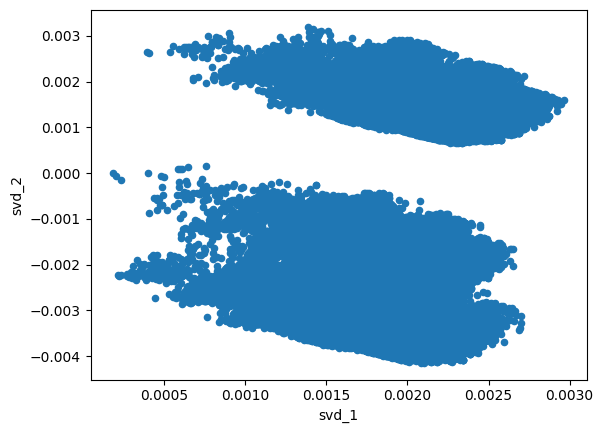

In [ ]:
features_rdd = demographic_df_normalize.select("household_id", "features").rdd.map(lambda row: (row.household_id, MLLibVectors.dense(row.features.toArray())))
mat = RowMatrix(features_rdd.map(lambda x: x[1]))
svd = mat.computeSVD(2, computeU=True)
U = svd.U

projected_df = features_rdd.zip(U.rows).map(lambda x: (
    x[0][0],
    x[0][1].toArray().tolist(),
    x[1].toArray().tolist()
)).toDF(["household_id", "original_features", "projected_features"])

projected_df = projected_df.withColumn("svd_1", col("projected_features")[0])
projected_df = projected_df.withColumn("svd_2", col("projected_features")[1])


display(projected_df.select("household_id", "original_features", "projected_features").limit(10))
projected_df.toPandas().plot.scatter(x='svd_1', y='svd_2')


## Clustering

In [ ]:
df = demographic_df_normalize.select("household_id", "features")

kmeans = KMeans(k=8, seed=7, featuresCol="features")
model = kmeans.fit(df)

df_with_clusters = model.transform(df)

centroids = model.clusterCenters()
broadcast_centroids = spark.sparkContext.broadcast(centroids)

def distance_and_centroid(features, cluster):
    centroid = broadcast_centroids.value[cluster]
    distance = sum((x - y) ** 2 for x, y in zip(features, centroid)) ** 0.5
    return float(distance)

distance_udf = udf(distance_and_centroid, DoubleType())

df_with_distances = df_with_clusters.withColumn(
    "distance_from_centroid",
    distance_udf(col("features"), col("prediction"))
)

display(df_with_distances.select("household_id", "features", "prediction", "distance_from_centroid").limit(10))

household_id,features,prediction,distance_from_centroid
15,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0))",2,1.450782563315443
28,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.2, 0.3888888888888889, 0.5, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7245586446112136
56,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.26666666666666666, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7831719347939347
61,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 1.0, 0.3888888888888889, 0.875, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",5,0.4757532522236078
98,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.26666666666666666, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))",3,0.6366364391274877
111,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.16666666666666666, 0.875, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7639255209838841
122,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.5333333333333333, 0.3333333333333333, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))",3,0.30510101093309056
130,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 0.5333333333333333, 0.3888888888888889, 0.625, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.5628629498957646
145,"Map(vectorType -> sparse, length -> 16, indices -> List(3, 4, 5, 10, 13, 14, 15), values -> List(0.2, 0.2777777777777778, 0.5, 1.0, 1.0, 1.0, 1.0))",6,1.236909318809367
160,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.2777777777777778, 0.625, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",6,0.7211004938403033


## Visual Clustering

household_id,features,prediction,distance_from_centroid,pca_features
15,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0))",2,1.450782563315443,"Map(vectorType -> dense, length -> 2, values -> List(0.28813137809056155, -0.9958620783545076))"
28,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.2, 0.3888888888888889, 0.5, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7245586446112136,"Map(vectorType -> dense, length -> 2, values -> List(0.1843991618917935, -1.0324235165319495))"
56,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.26666666666666666, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7831719347939347,"Map(vectorType -> dense, length -> 2, values -> List(0.2584861200037278, -1.0280513115368473))"
61,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 1.0, 0.3888888888888889, 0.875, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",5,0.4757532522236078,"Map(vectorType -> dense, length -> 2, values -> List(-1.2255110792896229, -0.9706140726906686))"
98,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.26666666666666666, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))",3,0.6366364391274877,"Map(vectorType -> dense, length -> 2, values -> List(-1.0895069959187025, -0.002050552412943926))"
111,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.16666666666666666, 0.875, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.7639255209838841,"Map(vectorType -> dense, length -> 2, values -> List(0.1534645637850226, -1.0106084265978124))"
122,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.2, 0.5, 0.5333333333333333, 0.3333333333333333, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))",3,0.30510101093309056,"Map(vectorType -> dense, length -> 2, values -> List(-1.1204431862196194, 0.009796392133612053))"
130,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 0.5333333333333333, 0.3888888888888889, 0.625, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",7,0.5628629498957646,"Map(vectorType -> dense, length -> 2, values -> List(0.1521701473223459, -1.0255308266001226))"
145,"Map(vectorType -> sparse, length -> 16, indices -> List(3, 4, 5, 10, 13, 14, 15), values -> List(0.2, 0.2777777777777778, 0.5, 1.0, 1.0, 1.0, 1.0))",6,1.236909318809367,"Map(vectorType -> dense, length -> 2, values -> List(-0.23800234905484932, -1.0503897954507146))"
160,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.2777777777777778, 0.625, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",6,0.7211004938403033,"Map(vectorType -> dense, length -> 2, values -> List(-0.2221993338766552, -1.147328087379702))"


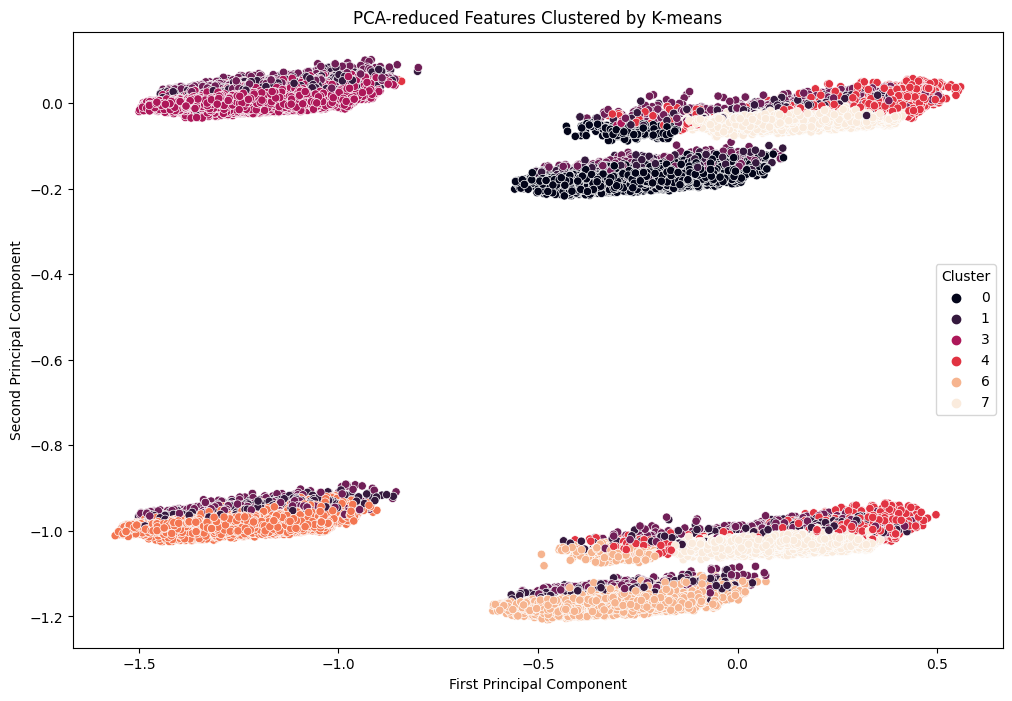

In [ ]:
from pyspark.ml.functions import vector_to_array

pca = PCA(inputCol="features", outputCol="pca_features", k=2)
reduced_features = pca.fit(df_with_distances).transform(df_with_distances)

display(reduced_features.limit(10))

# Convert PCA features to columns
reduced_features = reduced_features.select(
    "household_id",
    "prediction",
    vector_to_array("pca_features").alias("pca_features")
)
reduced_features = reduced_features.select(
    "household_id",
    "prediction",
    reduced_features.pca_features[0].alias("pca1"),
    reduced_features.pca_features[1].alias("pca2")
)

# Convert to Pandas DataFrame for visualization
pandas_df = reduced_features.toPandas()

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pandas_df, x="pca1", y="pca2", hue="prediction", palette="rocket")
plt.title("PCA-reduced Features Clustered by K-means")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend(title="Cluster")
plt.show()

## Dividing households into subsets

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy("prediction").orderBy("distance_from_centroid")
df_with_rank = df_with_distances.withColumn("rank", row_number().over(windowSpec))

seventh_subset = df_with_rank.where("rank % 7 == 0")
eleventh_subset = df_with_rank.where("rank % 11 == 0")

seventh_subset_dict = {}
eleventh_subset_dict = {}
full_subset_dict = {}

for i in range(8):
    full_subset_dict[f"full_subset_{i}"] = df_with_rank.where(f"prediction == {i}")
    seventh_subset_dict[f"seventh_subset_{i}"] = seventh_subset.where(f"prediction == {i}")
    eleventh_subset_dict[f"eleventh_subset_{i}"] = eleventh_subset.where(f"prediction == {i}")

In [ ]:
for dict_ in [full_subset_dict, seventh_subset_dict, eleventh_subset_dict]:
    for key, val in dict_.items():
        subset_name = key.split("_")[0]
        print(f"{subset_name} subset, cluster {key[-1]}:")
        val.show(10, truncate=False)

full subset, cluster 0:
+------------+------------------------------------------------------------------------------------------------------------------+----------+----------------------+----+
|household_id|features                                                                                                          |prediction|distance_from_centroid|rank|
+------------+------------------------------------------------------------------------------------------------------------------+----------+----------------------+----+
|3988444     |[0.25,0.4,0.5,0.5333333333333333,0.3333333333333333,0.625,0.3333333333333333,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0] |0         |0.18794519460027      |1   |
|3608088     |[0.25,0.4,0.5,0.6,0.3888888888888889,0.625,0.3333333333333333,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0]                |0         |0.19179988447268123   |2   |
|2310297     |[0.375,0.4,0.5,0.5333333333333333,0.3888888888888889,0.75,0.3333333333333333,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0] |0 

## Cluster’s Viewing Analysis

In [ ]:
# stage 1

subset_viewing_per_station = {}
seventh_subset_viewing_per_station = {}
eleventh_subset_viewing_per_station = {}

static_viewing_df.cache()

for key, val in full_subset_dict.items():
    subset_viewing_per_station[key] = val.join(static_viewing_df, on="household_id").groupBy("station_num").count().orderBy("count", ascending=False)

for key, val in seventh_subset_dict.items():
    seventh_subset_viewing_per_station[key] = val.join(static_viewing_df, on="household_id").groupBy("station_num").count().orderBy("count", ascending=False)

for key, val in eleventh_subset_dict.items():
    eleventh_subset_viewing_per_station[key] = val.join(static_viewing_df, on="household_id").groupBy("station_num").count().orderBy("count", ascending=False)

for i in range(8):
    print(f"amount of viewing events per station for the full subset cluster {i}:")
    subset_viewing_per_station[f"full_subset_{i}"].show(10, truncate=False)
    print(f"amount of viewing events per station for the seventh subset cluster {i}:")
    seventh_subset_viewing_per_station[f"seventh_subset_{i}"].show(10, truncate=False)
    print(f"amount of viewing events per station for the eleventh subset cluster {i}:")
    eleventh_subset_viewing_per_station[f"eleventh_subset_{i}"].show(10, truncate=False)



amount of viewing events per station for the full subset cluster 0:
+-----------+-----+
|station_num|count|
+-----------+-----+
|99993      |29993|
|60179      |6372 |
|16374      |5620 |
|32645      |5242 |
|99995      |4721 |
|10171      |4108 |
|14902      |4078 |
|49788      |3812 |
|12131      |3648 |
|14771      |3406 |
+-----------+-----+
only showing top 10 rows

amount of viewing events per station for the seventh subset cluster 0:
+-----------+-----+
|station_num|count|
+-----------+-----+
|99993      |4374 |
|60179      |949  |
|16374      |815  |
|32645      |742  |
|99995      |678  |
|14902      |602  |
|10171      |564  |
|49788      |549  |
|14771      |500  |
|10179      |480  |
+-----------+-----+
only showing top 10 rows

amount of viewing events per station for the eleventh subset cluster 0:
+-----------+-----+
|station_num|count|
+-----------+-----+
|99993      |2652 |
|60179      |548  |
|16374      |522  |
|14902      |419  |
|32645      |412  |
|99995      |404 

In [ ]:
# stage 2

for dict_ in [subset_viewing_per_station, seventh_subset_viewing_per_station, eleventh_subset_viewing_per_station]:
    for key, val in dict_.items():
        total_count = val.select(f.sum("count")).collect()[0][0]
        val = val.withColumn("rating", (val["count"] / total_count)*100)
        dict_[key] = val.select("station_num", "rating").orderBy("rating", ascending=False)

for i in range(8):
    print(f"the precent of viewing events per station for the full subset, cluster {i}:")
    subset_viewing_per_station[f"full_subset_{i}"].show(10, truncate=False)
    print(f"the precent of viewing events per station for the seventh subset, cluster {i}:")
    seventh_subset_viewing_per_station[f"seventh_subset_{i}"].show(10, truncate=False)
    print(f"the precent of viewing events per station for the eleventh subset, cluster {i}:")
    eleventh_subset_viewing_per_station[f"eleventh_subset_{i}"].show(10, truncate=False)

the precent of viewing events per station for the full subset, cluster 0:
+-----------+------------------+
|station_num|rating            |
+-----------+------------------+
|99993      |7.745445906092957 |
|60179      |1.6455166643424908|
|16374      |1.4513188408042683|
|32645      |1.353703445461917 |
|99995      |1.2191594746329093|
|10171      |1.0608572594348638|
|14902      |1.0531100058362644|
|49788      |0.9844176905953507|
|12131      |0.9420660375896746|
|14771      |0.8795715252276401|
+-----------+------------------+
only showing top 10 rows

the precent of viewing events per station for the seventh subset, cluster 0:
+-----------+------------------+
|station_num|rating            |
+-----------+------------------+
|99993      |7.74844995571302  |
|60179      |1.6811337466784766|
|16374      |1.4437555358724536|
|32645      |1.3144375553587246|
|99995      |1.2010628875110718|
|14902      |1.066430469441984 |
|10171      |0.9991142604074401|
|49788      |0.9725420726306466

In [ ]:
# stage 3
viewing_amount_full_data = static_viewing_df.groupBy("station_num").count().withColumnRenamed("count", "full_data_count")
print("amount of viewing events per station for the entire data:")
viewing_amount_full_data.orderBy("full_data_count", ascending=False).show(truncate=False)

total_count = viewing_amount_full_data.select(f.sum("full_data_count")).collect()[0][0]
viewing_amount_full_data = viewing_amount_full_data.withColumn("full_data_rating", (f.col("full_data_count") / total_count)*100)
print("the precent of viewing events per station for the entire data:")
viewing_amount_full_data.orderBy("full_data_rating", ascending=False).show(truncate=False)

amount of viewing events per station for the entire data:
+-----------+---------------+
|station_num|full_data_count|
+-----------+---------------+
|99993      |800201         |
|16374      |142003         |
|60179      |137138         |
|32645      |129320         |
|10171      |105204         |
|12131      |103763         |
|99995      |103330         |
|10179      |92164          |
|14902      |91332          |
|10142      |90415          |
|14771      |89195          |
|11187      |89133          |
|11207      |87081          |
|49788      |83291          |
|11221      |82527          |
|11867      |80921          |
|11150      |71803          |
|58515      |69083          |
|16615      |67846          |
|11164      |67569          |
+-----------+---------------+
only showing top 20 rows

the precent of viewing events per station for the entire data:
+-----------+---------------+------------------+
|station_num|full_data_count|full_data_rating  |
+-----------+---------------+------

In [ ]:
# stage 4

for dict_ in [subset_viewing_per_station, seventh_subset_viewing_per_station, eleventh_subset_viewing_per_station]:
    for key, val in dict_.items():
        val = val.join(viewing_amount_full_data, on="station_num").withColumn("diff_rank", f.col("rating") - f.col("full_data_rating"))
        dict_[key] = val.select("station_num", "diff_rank").orderBy("diff_rank", ascending=False)

for i in range(8):
    print(f"top 10 highest diff_rank station in the full subset for cluster {i} are:")
    subset_viewing_per_station[f"full_subset_{i}"].show(10, truncate=False)
    print(f"top 10 highest diff_rank station in the seventh subset for cluster {i} are:")
    seventh_subset_viewing_per_station[f"seventh_subset_{i}"].show(10, truncate=False)
    print(f"top 10 highest diff_rank station in the eleventh subset for cluster {i} are:")
    eleventh_subset_viewing_per_station[f"eleventh_subset_{i}"].show(10, truncate=False)

static_viewing_df.unpersist()

top 10 highest diff_rank station in the full subset for cluster 0 are:
+-----------+--------------------+
|station_num|diff_rank           |
+-----------+--------------------+
|60179      |0.28900310341080937 |
|99995      |0.19706095889642028 |
|49788      |0.16053684791454248 |
|14902      |0.14969084741910554 |
|11713      |0.09542935779355038 |
|59684      |0.09397652222975589 |
|19628      |0.08426652874308772 |
|32645      |0.07452237457211952 |
|50747      |0.06424401891450898 |
|58515      |0.054713965842232315|
+-----------+--------------------+
only showing top 10 rows

top 10 highest diff_rank station in the seventh subset for cluster 0 are:
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|60179      |0.3246201857467952 |
|99995      |0.1789643717745828 |
|14902      |0.16301131102482513|
|36069      |0.16188470145546666|
|49788      |0.14866122994983844|
|58646      |0.14401705686252642|
|29952      |0.10727562967443702|

DataFrame[device_id: string, event_date: int, event_time: int, station_num: string, prog_code: string, household_id: bigint]

# Dynamic Data Analysis - Streaming

In [ ]:
from pyspark.sql import functions as f

SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data"
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(f.from_csv(f.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

viewing_counts = streaming_df.groupBy("event_date").count()
count_viewing_query =viewing_counts.writeStream\
.queryName('num_viewing')\
.format("memory")\
.outputMode("complete")\
.start()


time.sleep(10)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewing_query.status)
    spark.sql('SELECT * FROM num_viewing').show()
    time.sleep(5)

count_viewing_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
+----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
+----------+-----+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|12582|
|  20151004|18896|
|  20151018|18522|
+----------+-----+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|30085|
|  20151004|35537|
|  20151018|34378|
+----------+-----+

Batch number: 4
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|4718

In [ ]:

global_state = {}
seventh_subsets = {name: subset.select("household_id") for name, subset in seventh_subset_dict.items()}

for df in seventh_subsets.values():
    df.cache()

batch_num = 0

def process_batch(df, batch_id):
    df = df.withColumn("household_id", col("household_id").cast(LongType()))
    df.cache()

    global global_state
    global batch_num
    global seventh_subsets

    batch_num += 1

    # stage 1
    popularity_per_station = {}
    for name, subset_df in seventh_subsets.items():
            popularity_per_station[name] = df.join(subset_df, on="household_id").groupBy("station_num").agg(f.count("*").alias("count"))

    # stage 2
    for name, subset_df in popularity_per_station.items():
        total_count = subset_df.select(f.sum("count")).collect()[0][0]
        popularity_per_station[name] = subset_df.withColumn(
            "popularity",
            (f.col("count") / total_count) * 100
            ).select("station_num", "popularity")

    # stage 3
    entire_data_popularity = df.groupBy("station_num").agg(f.count("*").alias("overall_count"))
    total_count = entire_data_popularity.select(f.sum("overall_count")).collect()[0][0]
    entire_data_popularity = entire_data_popularity.withColumn(
        "overall_popularity",
        (f.col("overall_count") / total_count) * 100
    ).select("station_num", "overall_popularity")

    # stage 4
    for name, subset_df in popularity_per_station.items():
        popularity_per_station[name] = subset_df.join(entire_data_popularity, on="station_num") \
            .withColumn("diff_rank", f.col("popularity") - f.col("overall_popularity"))

    for name, subset_df in popularity_per_station.items():
        if name not in global_state:
            global_state[name] = subset_df
        else:
            subset_df = subset_df.withColumnRenamed("diff_rank", "diff_rank_updated")
            update_global = global_state[name].join(subset_df, on="station_num", how="outer").fillna(0)
            global_state[name] = update_global.withColumn("diff_rank", \
                (col('diff_rank') * (batch_num-1) * OFFSETS_PER_TRIGGER \
                + col('diff_rank_updated') * OFFSETS_PER_TRIGGER) \
                / (batch_num * OFFSETS_PER_TRIGGER)).select("station_num", "diff_rank")

    print(f"Batch number {batch_num}:")
    for name, subset_df in global_state.items():
        print(f"Cluster {name[-1]}:")
        subset_df.select("station_num","diff_rank").orderBy("diff_rank", ascending=False).show(10, truncate=False)
    df.unpersist()

query = streaming_df.writeStream \
    .foreachBatch(process_batch) \
    .option("failOnDataLoss", "false") \
    .start()

while batch_num <= 3:
    time.sleep(5)

query.stop()

for df in seventh_subsets.values():
    df.unpersist()

Batch number 1:
Cluster 0:
+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|19580      |13.877870967741936|
|20367      |12.653548387096773|
|10918      |6.196193548387098 |
|60222      |5.989032258064516 |
|64549      |5.371870967741936 |
|99993      |3.259290322580645 |
|59684      |3.2303870967741934|
|99995      |2.817870967741936 |
|60150      |2.801225806451613 |
|66268      |2.757806451612903 |
+-----------+------------------+
only showing top 10 rows

Cluster 1:
+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|11221      |35.71418604651163 |
|18480      |6.576744186046511 |
|16331      |6.079627906976744 |
|11207      |4.104279069767442 |
|11380      |3.4689302325581393|
|11097      |3.2889302325581395|
|16617      |2.981813953488372 |
|16715      |2.6266976744186046|
|11006      |2.4198139534883722|
|11593      |1.9326976744186046|
+-----------+------------------+
only showing